## Work done by: Mohammad Al-Refaie & Abdulrahman Ghazal
**-----------------------------------------------------------------------------------------------------------------------------**

## Lung Disease Classification Using MobileNet with GUI for testing

**This project leverages a pre-trained MobileNet model to classify lung diseases from chest X-ray images. The model can differentiate between three categories: Lung Opacity, Normal, and Viral Pneumonia. A user-friendly GUI, built with Tkinter and OpenCV, allows users to upload chest X-ray images and receive real-time predictions along with confidence levels.**

**The application preprocesses the uploaded images, normalizes them, and feeds them into the MobileNet model for classification. The result, along with the confidence percentage, is displayed on the interface alongside the uploaded image for easy visualization.**

## Importing Libraries

In [22]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import MobileNet
from tensorflow.keras import layers, models, callbacks
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adamax, Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.saving import register_keras_serializable
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import os
import cv2

## Organizing and preparing the dataset for processing

In [9]:
Lung_Opacity = [r"C:\Users\mohdh\Desktop\TTU\Deep Learning\Lung X-Ray Image\Lung X-Ray Image\Lung_Opacity"]
Normal = [r"C:\Users\mohdh\Desktop\TTU\Deep Learning\Lung X-Ray Image\Lung X-Ray Image\Normal"]
Viral_Pneumonia = [r"C:\Users\mohdh\Desktop\TTU\Deep Learning\Lung X-Ray Image\Lung X-Ray Image\Viral Pneumonia"]
file_p = []
labels = []
dict_lists = [Normal, Lung_Opacity,Viral_Pneumonia]
class_labels = ['Normal', 'Lung Opacity','Viral Pneumonia']

for i, dir_list in enumerate(dict_lists):
     for j in dir_list:
            list_f = os.listdir(j)
            for name in list_f:
                fpath = os.path.join(j, name)
                file_p.append(fpath)
                labels.append(class_labels[i])


failpath = pd.Series(file_p, name="filepaths")
Labelss = pd.Series(labels, name="labels")
data = pd.concat([failpath, Labelss], axis=1)
df = pd.DataFrame(data)

In [10]:
df.head()

filepaths  labels
0  C:\Users\mohdh\Desktop\TTU\Deep Learning\Lung ...  Normal
1  C:\Users\mohdh\Desktop\TTU\Deep Learning\Lung ...  Normal
2  C:\Users\mohdh\Desktop\TTU\Deep Learning\Lung ...  Normal
3  C:\Users\mohdh\Desktop\TTU\Deep Learning\Lung ...  Normal
4  C:\Users\mohdh\Desktop\TTU\Deep Learning\Lung ...  Normal

## Train-test-validation split

In [13]:
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42,stratify=df.labels)
train_df, val_df = train_test_split(train_df, test_size=0.1, random_state=42,stratify=train_df.labels)
print(train_df.shape)
print(test_df.shape)
print(val_df.shape)

(2497, 2)
(694, 2)
(278, 2)


In [ ]:
def enhance_image(image):
    image = cv2.addWeighted(image, 1.5, image, -0.5, 0)

    kernel = np.array([[0, -1, 0], [-1, 5, -1], [0, -1, 0]])
    image = cv2.filter2D(image, -1, kernel)

    hue = image[:, :, 0]
    saturation = image[:, :, 1]
    value = image[:, :, 2]
    value = np.clip(value * 1.25, 0, 255)

    image[:, :, 2] = value

    return image

## MobileNet architecture

In [36]:
# Register keras serializable
@register_keras_serializable(package='Custom', name='CustomModel')
def custom_model():
    base_model = MobileNet(weights='imagenet', include_top=False, input_shape=(256, 256, 3), pooling='max')
    base_model.trainable = False  # Freeze the base model

    x = base_model.output
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.45)(x)
    predictions = Dense(3, activation='softmax')(x)

    model = models.Model(inputs=base_model.input, outputs=predictions)
    return model

## Data generators for training, validation, and testing

In [16]:
# Set image size
IMG_SIZE = 256

# Data Augmentation for Training
train_image_gen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,       # Rotate images up to 20 degrees
    width_shift_range=0.1,   # Shift images horizontally by up to 10% of width
    height_shift_range=0.1,  # Shift images vertically by up to 10% of height
    zoom_range=0.2,          # Zoom in/out by up to 20%
    horizontal_flip=True,    # Flip images horizontally
    fill_mode='nearest',
    preprocessing_function=lambda image: enhance_image(image)
)

val_test_image_gen = ImageDataGenerator(
    rescale=1./255,
    fill_mode='nearest',
    preprocessing_function=lambda image: enhance_image(image)
)

# Training Data Generator
train = train_image_gen.flow_from_dataframe(
    dataframe=train_df,
    x_col="filepaths",
    y_col="labels",
    target_size=(IMG_SIZE, IMG_SIZE),
    color_mode='rgb',
    class_mode="categorical",
    batch_size=32,
    shuffle=False  # Shuffle for better training
)

# Validation Data Generator
val = val_test_image_gen.flow_from_dataframe(
    dataframe=val_df,
    x_col="filepaths",
    y_col="labels",
    target_size=(IMG_SIZE, IMG_SIZE),
    color_mode='rgb',
    class_mode="categorical",
    batch_size=32,
    shuffle=False  # No shuffle to preserve validation consistency
)

# Test Data Generator
test = val_test_image_gen.flow_from_dataframe(
    dataframe=test_df,
    x_col="filepaths",
    y_col="labels",
    target_size=(IMG_SIZE, IMG_SIZE),
    color_mode='rgb',
    class_mode="categorical",
    batch_size=32,
    shuffle=False  # No shuffle to preserve test consistency
)


Found 2497 validated image filenames belonging to 3 classes.
Found 278 validated image filenames belonging to 3 classes.
Found 694 validated image filenames belonging to 3 classes.


## Samples of the dataset images

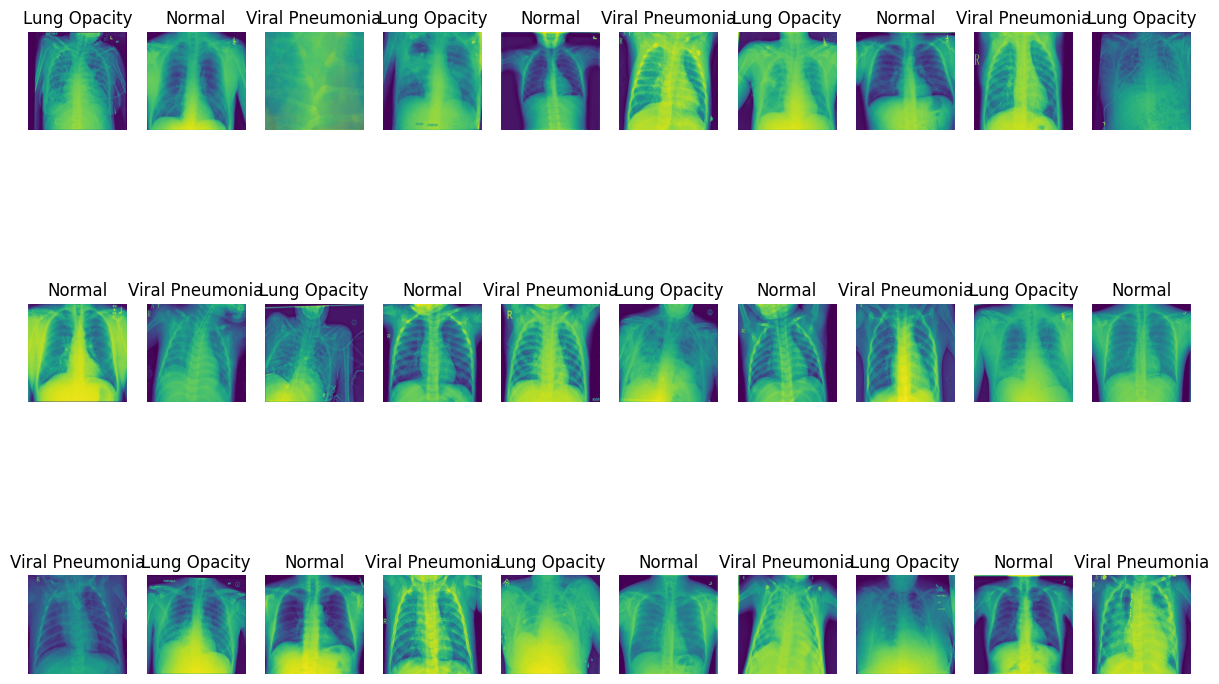

In [17]:
# Define the number of images to display from each class
num_images_per_class = 10

# Get class labels
class_labels = list(train.class_indices.keys())

# Plot images from each class
plt.figure(figsize=(15, 10))
for label in class_labels:
    # Get indices of images belonging to the current class
    indices = train_df[train_df['labels'] == label].index
    
    # Randomly sample a subset of indices if there are more than the desired number of images per class
    indices = np.random.choice(indices, min(num_images_per_class, len(indices)), replace=False)
    
    # Plot images
    for i, idx in enumerate(indices):
        plt.subplot(len(class_labels), num_images_per_class, len(class_labels)*i + class_labels.index(label) + 1)
        plt.imshow(plt.imread(train_df.loc[idx, 'filepaths']))  # Load and plot the image
        plt.title(label)
        plt.axis('off')
plt.show()

## Training process

In [39]:
# Load the base model
model = custom_model()

# Compile the model
optimizer = Adamax(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Callbacks
early_stopping = callbacks.EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True)
model_checkpoint = callbacks.ModelCheckpoint(
    r'C:\\Users\\mohdh\\Desktop\\TTU\\Deep Learning\\Project\\best_mobilenet_model.keras',
    monitor='val_loss',
    save_best_only=True
)

# Train the model
history = model.fit(
    train,
    validation_data=val,
    epochs=20,
    callbacks=[early_stopping, model_checkpoint]
)

# Save the final model
model.save(r'C:\\Users\\mohdh\\Desktop\\TTU\\Deep Learning\\Project\\final_mobilenet_model.h5')


C:\Users\mohdh\AppData\Local\Temp\ipykernel_12392\2509946054.py:4: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNet(weights='imagenet', include_top=False, input_shape=(256, 256, 3), pooling='max')


Epoch 1/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 65s 779ms/step - accuracy: 0.6933 - loss: 0.8670 - val_accuracy: 0.8525 - val_loss: 0.4441
Epoch 2/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 70s 881ms/step - accuracy: 0.8650 - loss: 0.3636 - val_accuracy: 0.8849 - val_loss: 0.3642
Epoch 3/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 82s 1s/step - accuracy: 0.9110 - loss: 0.2473 - val_accuracy: 0.8813 - val_loss: 0.3384
Epoch 4/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 70s 880ms/step - accuracy: 0.9286 - loss: 0.1966 - val_accuracy: 0.9029 - val_loss: 0.3078
Epoch 5/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 60s 759ms/step - accuracy: 0.9393 - loss: 0.1646 - val_accuracy: 0.9065 - val_loss: 0.3104
Epoch 6/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 62s 784ms/step - accuracy: 0.9492 - loss: 0.1479 - val_accuracy: 0.9029 - val_loss: 0.3109
Epoch 7/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 61s 771ms/step - accuracy: 0.9637 - loss: 0.1109 - val_accuracy: 0.9065 - val_loss: 0.3073
Epoch 8/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 63s 798ms/step - accuracy: 0.9583 - loss: 0.1095 - val_accurac

In [40]:
# Evaluate the model
val_steps = len(val)
y_true = val.classes
y_pred = np.argmax(model.predict(val, steps=val_steps), axis=1)

9/9 ━━━━━━━━━━━━━━━━━━━━ 8s 754ms/step


## Accuracy and Loss plots

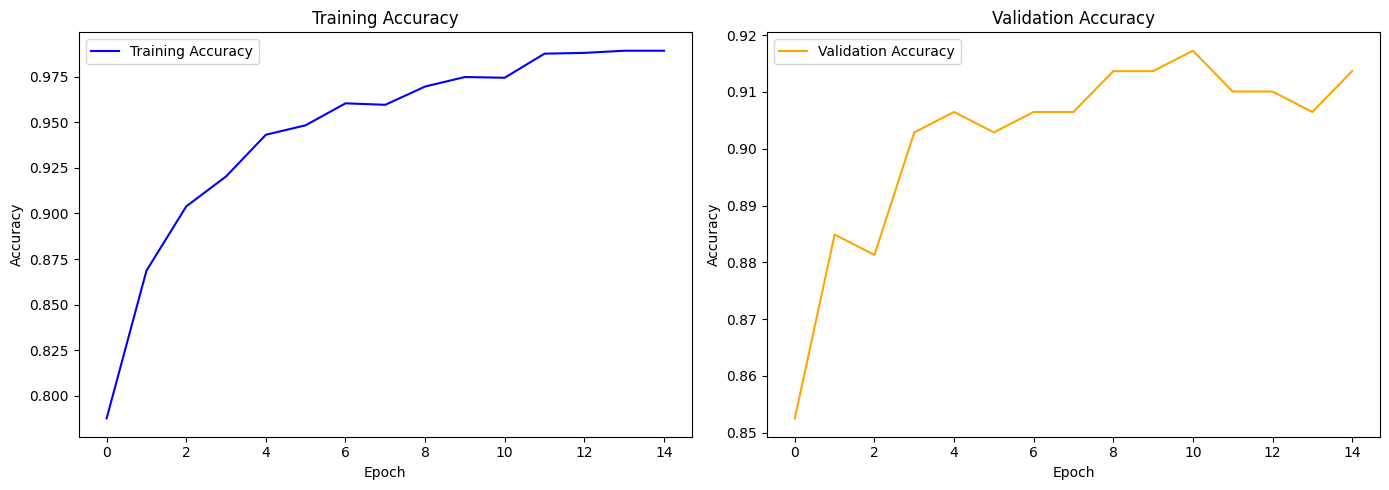

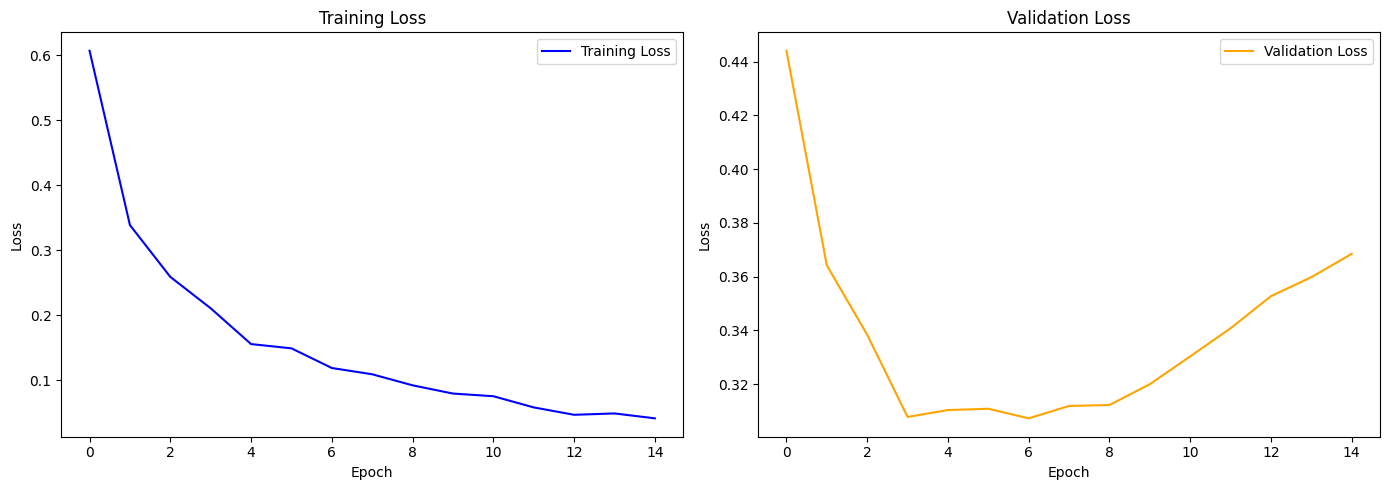

In [42]:
import matplotlib.pyplot as plt
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
train_loss = history.history['loss']
val_loss = history.history['val_loss']
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.plot(train_accuracy, label='Training Accuracy', color='blue')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training Accuracy')
plt.legend()


# Plot validation accuracy
plt.subplot(1, 2, 2)
plt.plot(val_accuracy, label='Validation Accuracy', color='orange')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


# Plot training and validation loss
plt.figure(figsize=(14, 5))

# Plot training loss
plt.subplot(1, 2, 1)
plt.plot(train_loss, label='Training Loss', color='blue')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()

# Plot validation loss
plt.subplot(1, 2, 2)
plt.plot(val_loss, label='Validation Loss', color='orange')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Validation Loss')
plt.legend()

plt.tight_layout()
plt.show()

## Confusion matrix

22/22 ━━━━━━━━━━━━━━━━━━━━ 16s 713ms/step


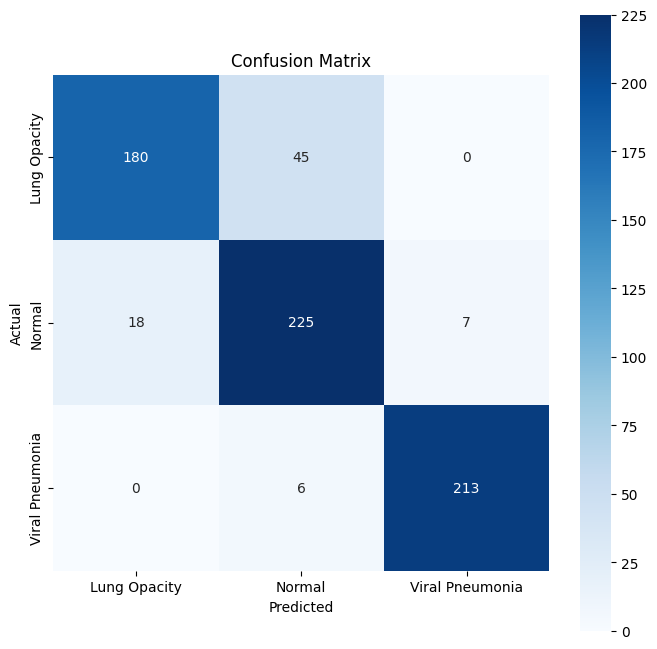

In [43]:
from sklearn.metrics import confusion_matrix
import numpy as np

# Get predictions for the test data
y_pred = model.predict(test)
y_pred_classes = np.argmax(y_pred, axis=1)

# Get true labels for the test data
true_classes = test.classes

# Compute confusion matrix
conf_matrix = confusion_matrix(true_classes, y_pred_classes)

# Plot confusion matrix
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', square=True, 
            xticklabels=test.class_indices.keys(), yticklabels=test.class_indices.keys())
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

## Classification report

In [47]:
# Generate predictions and ensure the length matches y_true
y_pred = np.argmax(model.predict(val, steps=int(np.ceil(val.n / val.batch_size))), axis=1)

# Slice predictions to match the exact number of true labels
y_pred = y_pred[:val.n]

# Generate classification report
class_labels = list(val.class_indices.keys())
report = classification_report(y_true, y_pred, target_names=class_labels)
print(report)


9/9 ━━━━━━━━━━━━━━━━━━━━ 7s 722ms/step
                 precision    recall  f1-score   support

   Lung Opacity       0.87      0.89      0.88        90
         Normal       0.89      0.85      0.87       100
Viral Pneumonia       0.97      0.99      0.98        88

       accuracy                           0.91       278
      macro avg       0.91      0.91      0.91       278
   weighted avg       0.91      0.91      0.91       278



## Few correctly classified and misclassified images

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


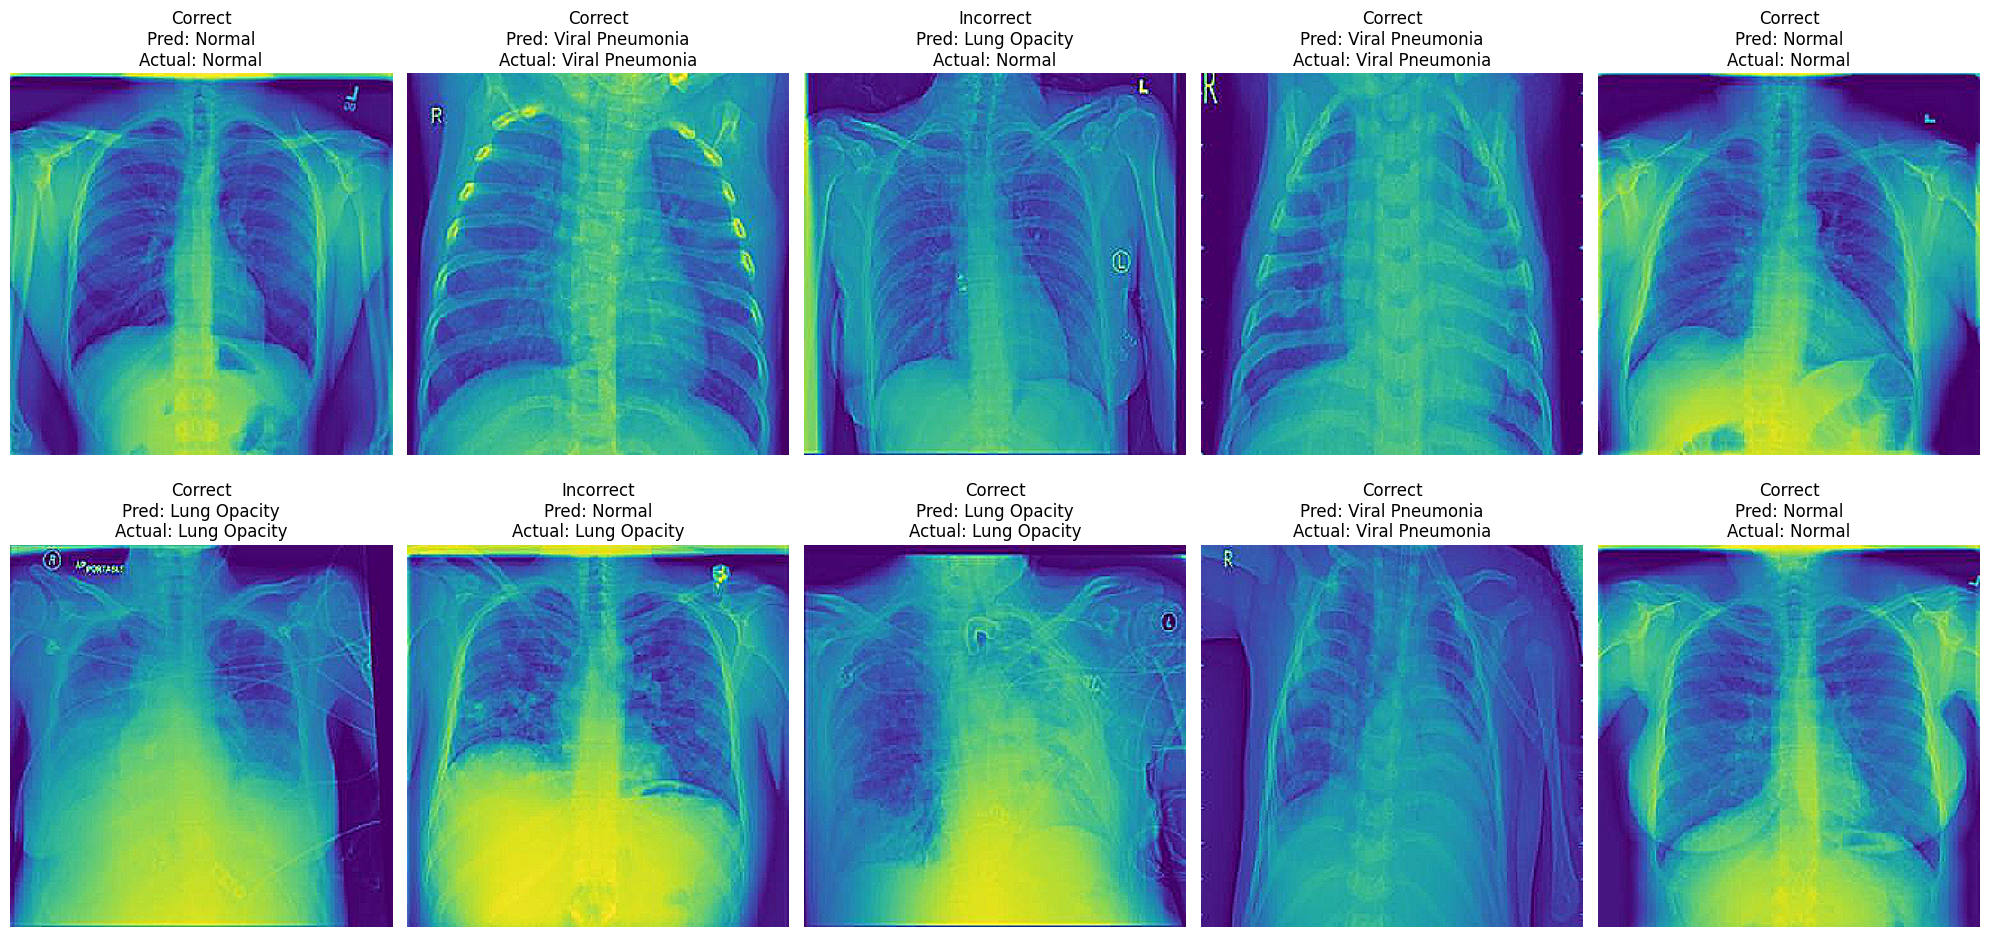

In [24]:
from tensorflow.keras.models import load_model
model = load_model(r"C:\Users\mohdh\Desktop\TTU\Deep Learning\Project\final_mobilenet_model.h5")


def visualize_predictions(generator, model, num_images=10):
    # Get a batch of images and labels
    x, y = next(generator)
    y_pred = model.predict(x)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_true_classes = np.argmax(y, axis=1)
    
    class_labels = list(generator.class_indices.keys())
    
    fig, axes = plt.subplots(2, 5, figsize=(20, 10))
    axes = axes.flatten()

    for i in range(num_images):
        ax = axes[i]
        ax.imshow(x[i])
        ax.axis('off')
        
        if y_pred_classes[i] == y_true_classes[i]:
            ax.set_title(f'Correct\nPred: {class_labels[y_pred_classes[i]]}\nActual: {class_labels[y_true_classes[i]]}')
        else:
            ax.set_title(f'Incorrect\nPred: {class_labels[y_pred_classes[i]]}\nActual: {class_labels[y_true_classes[i]]}')
    
    plt.tight_layout()
    plt.show()

# Visualize 10 images from the validation set
visualize_predictions(val, model, num_images=10)


## GUI code

In [1]:
import tkinter as tk
from tkinter import filedialog
from tkinter import Label, Button
from tensorflow.keras.models import load_model
import cv2
from PIL import Image, ImageTk
import numpy as np

# Load the model
model_path = r"C:\Users\mohdh\Desktop\TTU\Deep Learning\Project\final_mobilenet_model.h5"
model = load_model(model_path)

# Class labels (modify according to your model)
class_labels = ['Lung_Opacity', 'Normal', 'Viral Pneumonia']

# Image preprocessing function
def preprocess_image(img_path):
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (256, 256))
    img = np.expand_dims(img, axis=0)
    img = img / 255.0  # Normalize
    return img

# Classification function
def classify_image(img_path):
    processed_img = preprocess_image(img_path)
    prediction = model.predict(processed_img)
    
    predicted_class = np.argmax(prediction)
    confidence = np.max(prediction) * 100  # Get confidence percentage

    result_label.config(
        text=f"Prediction: {class_labels[predicted_class]}\nConfidence: {confidence:.2f}%"
    )
    
    display_image(img_path)

# Upload and classify image
def upload_image():
    file_path = filedialog.askopenfilename()
    if file_path:
        classify_image(file_path)

# Display image in GUI
def display_image(img_path):
    img = Image.open(img_path)
    img = img.resize((300, 300))
    img_tk = ImageTk.PhotoImage(img)
    img_label.config(image=img_tk)
    img_label.image = img_tk

# GUI design
root = tk.Tk()
root.title("Image Classifier")
root.geometry("500x600")
root.configure(bg='lightblue')

title_label = Label(root, text="Lung Disease Classifier", font=("Helvetica", 18), bg='lightblue')
title_label.pack(pady=20)

upload_button = Button(root, text="Upload Image", command=upload_image, font=("Helvetica", 14), bg='green', fg='white')
upload_button.pack(pady=20)

img_label = Label(root)
img_label.pack(pady=20)

result_label = Label(root, text="", font=("Helvetica", 16), bg='lightblue')
result_label.pack(pady=20)

exit_button = Button(root, text="Exit", command=root.destroy, font=("Helvetica", 14), bg='red', fg='white')
exit_button.pack(pady=20)

root.mainloop()


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 654ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


## Observations and Conclusion

The model achieves a high accuracy of 91%, indicating strong performance across all classes.
The macro average (91%) suggests that the model treats each class fairly, without significant bias toward any particular category.
Excellent Performance on "Viral Pneumonia"

The precision, recall, and F1-score for Viral Pneumonia are the highest at 0.97, 0.99, and 0.98 respectively.
Only 6 cases were misclassified as "Normal," suggesting the model distinguishes viral pneumonia very effectively.
Balanced Performance on "Lung Opacity" and "Normal"

Lung Opacity shows 0.87 precision and 0.89 recall, indicating the model is slightly better at identifying true positive cases.
For Normal cases, the recall is slightly lower at 0.85, meaning the model occasionally misclassifies normal images.
Misclassifications

45 "Lung Opacity" cases were misclassified as "Normal". This is the most prominent misclassification.
18 "Normal" cases were misclassified as "Lung Opacity".
7 "Normal" cases were misclassified as Viral Pneumonia.

Model Generalization: While the model performs well on the test set, its generalization to unseen data (used in GUI) is great and achieves high confidence levels across all the 3 classes.